In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

import twitch_data


video_id = "258310143"
#video_id = "258493564"

In [2]:
twitch_data.init_directory_structure()

256964604

Finish in 28.160229206085205
23416
Finish in 117.14467406272888
23385

In [3]:
video_infos = twitch_data.load_video_infos('epicenter_en1')
clips = twitch_data.load_clips('epicenter_en1')
chats = twitch_data.load_chats(video_id)

In [4]:
video2clips = {clip.video_id:[] for clip in clips}
for clip in clips:
    video2clips[clip.video_id].append(clip)
video_related_clips = video2clips[video_id]

In [5]:
video_info = twitch_data.twitch_get_video_info(video_id)
video_length = twitch_data.duration_str_to_seconds(video_info['duration'])

In [6]:
durations = list(map(lambda x:x.duration, video_related_clips))
print("Clip max duration(sec):", max(durations))
print("Clip min duration(sec):", min(durations))
print("Clips average duration(sec):", sum(durations) / len(durations))
print("Clips duration(sec):", sum(durations))
print("Video duration(s):", video_length)

Clip max duration(sec): 60.01
Clip min duration(sec): 5.01
Clips average duration(sec): 27.930676328502486
Clips duration(sec): 11563.300000000028
Video duration(s): 33507


In [7]:
import twitch_feature
sample_window_size = 20

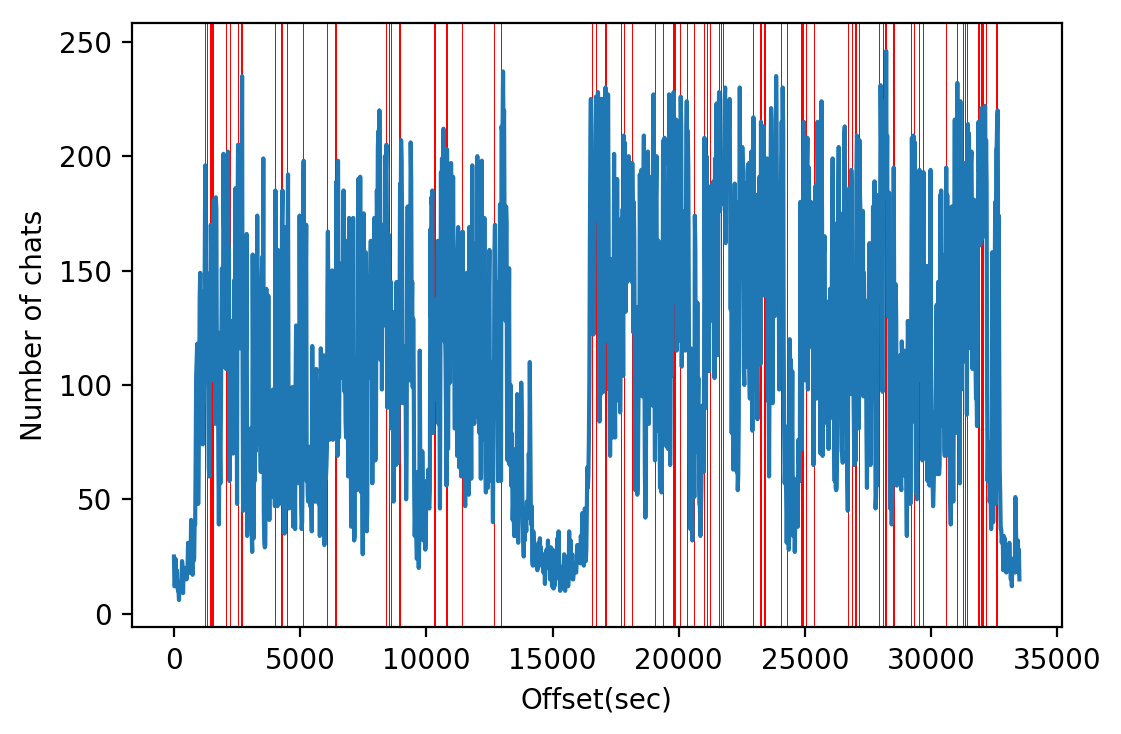

In [8]:
def plot_chats_density(chats, clips, video_length, sample_window_size, chats_density):
    fig = plt.figure(dpi=200)
    plt.xlabel("Offset(sec)")
    plt.ylabel("Number of chats")

    plot_x = range(0, video_length, sample_window_size)
    
    for clip in clips:
        plt.axvspan(clip.video_offset, clip.video_offset + clip.duration, facecolor='r')
    plt.plot(plot_x, chats_density)
    return fig

chats_density = twitch_feature.calculate_chats_density(chats, video_length, sample_window_size)
plot_chats_density(chats, video_related_clips, video_length, sample_window_size, chats_density)
plt.show()

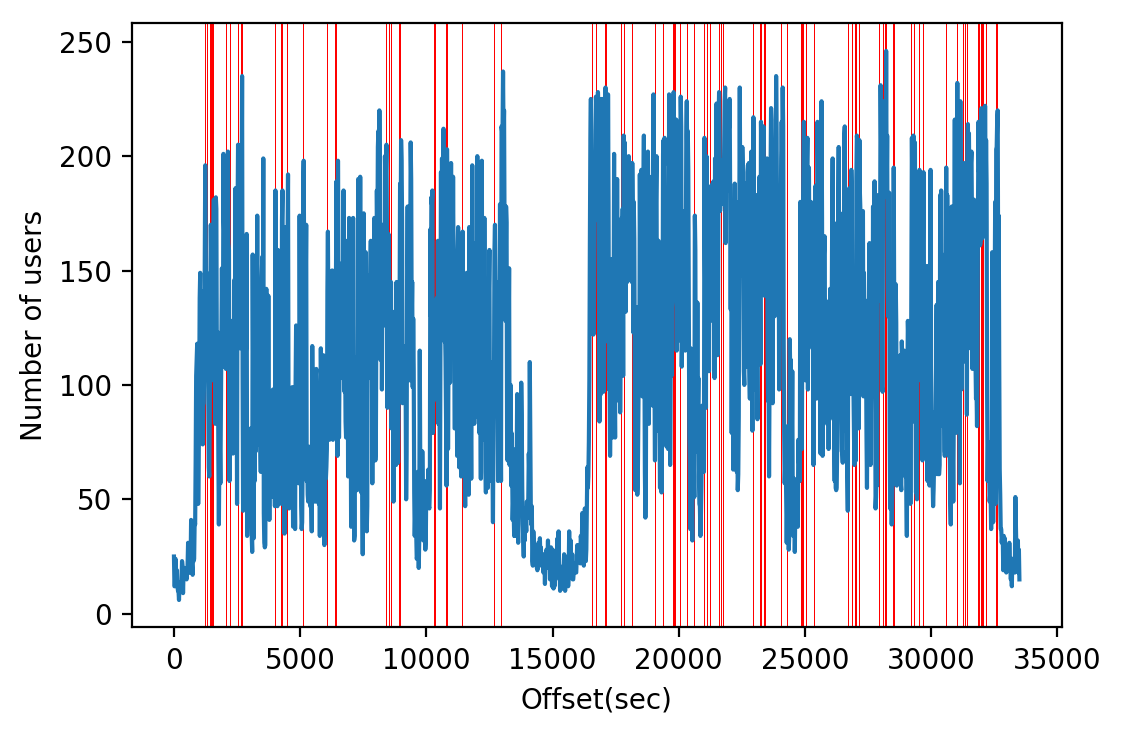

In [9]:
def plot_active_user_density(chats, clips, video_length, sample_window_size, activer_user_density):
    fig = plt.figure(dpi=200)
    plt.xlabel("Offset(sec)")
    plt.ylabel("Number of users")

    plot_x = range(0, video_length, sample_window_size)
    if activer_user_density is None:
        activer_user_density = calculate_chats_density(chats, video_length, sample_window_size)
    
    for clip in clips:
        plt.axvspan(clip.video_offset, clip.video_offset + clip.duration, facecolor='r')
    plt.plot(plot_x, chats_density)
    return fig

activer_user_density = twitch_feature.calculate_active_user_density(chats, video_length, sample_window_size)
plot_active_user_density(chats, video_related_clips, video_length, sample_window_size, activer_user_density)
plt.show()

In [11]:
labels = twitch_feature.calculate_label(video_related_clips, video_length, sample_window_size)

In [12]:
print("Clip average # of chats:", np.mean(chats_density[labels == 1]))
print("Other parts average # of chats:", np.mean(chats_density[labels == 0]))
print("Clip variance of # of chats:", np.var(chats_density[labels == 1]))
print("Other parts variance of # of chats:", np.var(chats_density[labels == 0]))
print("Clip average # of active users:", np.mean(chats_density[labels == 1]))
print("Other parts average # of active users:", np.mean(activer_user_density[labels == 0]))
print("Clip variance of # of active users:", np.var(activer_user_density[labels == 1]))
print("Other parts variance of # of active users:", np.var(activer_user_density[labels == 0]))

Clip average # of chats: 152.70967741935485
Other parts average # of chats: 102.96218487394958
Clip variance of # of chats: 2543.0366805411027
Other parts variance of # of chats: 3343.2968893439734
Clip average # of active users: 152.70967741935485
Other parts average # of active users: 98.79131652661064
Clip variance of # of active users: 2310.5120805150887
Other parts variance of # of active users: 3059.6469273984103


In [26]:
texts = twitch_feature.extract_text(chats, video_length, sample_window_size)
vectorizer, tfidf_features = twitch_feature.train_and_transform_tfidf(texts)

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

print("Cos similarity between clips \t\t\t%f" % np.mean(cosine_similarity(tfidf_features[labels == 1], tfidf_features[labels == 1])))
print("Cos similarity between clips and unclips \t%f" % np.mean(cosine_similarity(tfidf_features[labels == 1], tfidf_features[labels == 0])))
print("Cos similarity between unclips \t\t\t%f" %np.mean(cosine_similarity(tfidf_features[labels == 0], tfidf_features[labels == 0])))

Cos similarity between clips 			0.121497
Cos similarity between clips and unclips 	0.089021
Cos similarity between unclips 			0.080610


In [46]:
from wordcloud import WordCloud
from collections import Counter

clip_concat_feature = np.asarray(np.sum(tfidf_features[labels == 1], axis=0)).squeeze()
unclip_concnat_feature = np.asarray(np.sum(tfidf_features[labels == 0], axis=0)).squeeze()
index2word = {v:k for k,v in vectorizer.vocabulary_.items()}
clip_chats_counter = {}
unclip_chats_counter = {}
for i in index2word:
    clip_chats_counter[index2word[i]] = clip_concat_feature[i]
    unclip_chats_counter[index2word[i]] = unclip_concnat_feature[i]

In [47]:
a = sorted(list(clip_chats_counter.items()), key=lambda x: -x[1])
b = sorted(list(unclip_chats_counter.items()), key=lambda x: -x[1])
for top in [10, 50, 100]:
    overlap = 0
    top_word_a = [tu[0] for tu in a[:top]]
    top_word_b = [tu[0] for tu in b[:top]]
    for word in top_word_a:
        if word in top_word_b:
            overlap += 1
    print("Top %d\toverlap:\t" % top, overlap,'/',top,"\t", overlap/top)

Top 10	overlap:	 7 / 10 	 0.7
Top 50	overlap:	 35 / 50 	 0.7
Top 100	overlap:	 74 / 100 	 0.74


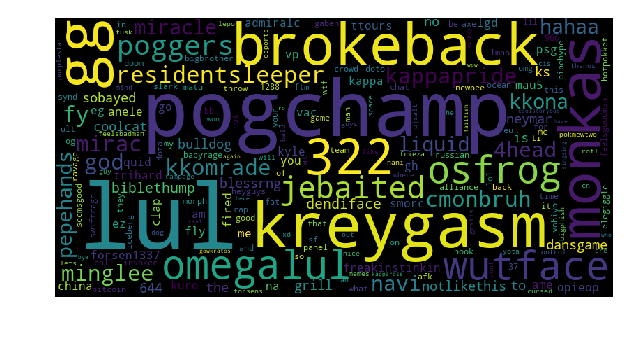

In [48]:
clip_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(clip_chats_counter)

plt.figure(dpi=120)
plt.imshow(clip_wordcloud)
plt.axis("off")
plt.show()

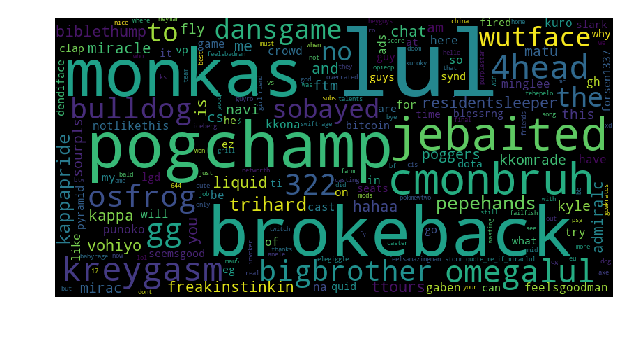

In [49]:
unclip_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(unclip_chats_counter)

plt.figure(dpi=120)
plt.imshow(unclip_wordcloud)
plt.axis("off")
plt.show()

In [ ]:
from IPython.display import HTML
def twitch_play_video(video_id, offset):
    html_str = '<iframe src="https://player.twitch.tv/?autoplay=false&t=%ds&video=%s" frameborder="0" allowfullscreen="true" scrolling="no" height="378" width="620"></iframe>' % (offset, video_id)
    return HTML(data=html_str)

twitch_play_video(video_id, related_clips[0].video_offset)